Lab1 – Problem 1 & Problem 2
----------------------------------------------
> Student Name: Zhang Jingxuan
> Student Number: A0326409A
- Problem 1:
  Use Numerical Recipes LU (ludcmp + lubksb) to solve a 4x4 Ax=b,
  then verify correctness by consistency check (residual), and compare
  with SciPy (or NumPy) solver including timings.

- Problem 2:
  Build the linear system for an LxL unit-resistor square grid with
  boundary voltages V(A)=0 at (0,0) and V(B)=1 at (L,L). Solve for node
  voltages (unknown nodes), compute total current flowing *out of B*,
  and repeat for multiple L. Compare NR-LU result with SciPy/NumPy and time both.

## Theory (Problem 1): LU with Partial Pivoting + Residual Check

We factorize $A$ by **Crout** LU:
$$
A = LU
$$
where $L$ is unit-lower-triangular and $U$ is upper-triangular.

For column $j$, we update each entry:
$$
a_{ij} \leftarrow a_{ij} - \sum_{k=0}^{\ell-1} a_{ik}\,a_{kj}, \qquad \ell=\min(i,j).
$$

Then we pivot (swap rows) to place the largest **scaled** element on the diagonal
(partial pivoting with row scaling $v_i = 1/\max_j |a_{ij}|$) for numerical stability.

Solve $Ax=b$ via
$$
\begin{aligned}
Ly &= P\,b,\\
Ux &= y.
\end{aligned}
$$

**Consistency check**: compute
$
r = b - A x,
\max_i |r_i|,\quad \|r\|_2,\quad \frac{\|r\|_2}{\|b\|_2+\varepsilon}.
$
Small residuals (about $10^{-12}$ to $10^{-15}$) indicate a correct and stable implementation.

## Theory (Problem 2): Resistor Grid → Discrete Laplacian

Treat the $(L+1)\times(L+1)$ lattice with four-neighbour connections, resistance $r=1\ \Omega$ on each edge.
Let $A=(0,0)$ be fixed at $V_A=0$ and $B=(L,L)$ at $V_B=1$. For any **unknown** node $(i,j)$, by KCL:
$$
\sum_{(p,q)\in\mathcal N(i,j)}\frac{V_{i,j}-V_{p,q}}{r}=0
\ \Rightarrow\
\deg(i,j)\,V_{i,j}-\sum_{(p,q)\in\mathcal N(i,j)}V_{p,q}
=\sum_{\text{fixed neighbours}}V_{\text{fixed}}.
$$
This is the discrete Laplace equation with Dirichlet boundary conditions at A and B.

After solving voltages, total current **out of B** is
$$
I_B = \sum_{(p,q)\in\mathcal N(B)} \frac{V_B - V_{p,q}}{r}.
$$
For **L=2**, by diagonal symmetry, both neighbours of B have $V=2/3$, hence
$I_B = 2 \times (1 - 2/3) = 2/3\ \mathrm{A}$.

In [41]:
# Imports
import time
import math
from typing import Tuple, Dict, List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import scipy.linalg as la_ref
    REF_NAME = "SciPy"
except Exception:
    import numpy.linalg as la_ref
    REF_NAME = "NumPy"

In [42]:
# Fuctions
def ludcmp(a: List[List[float]], n: int, indx: List[int], d: List[float]) -> None:
    """
    In-place LU decomposition with partial pivoting.
    a: list-of-list, overwritten to store the combined L and U factors.
    indx: pivot index vector (output).
    d: list of size 1; d[0] flips sign on each row swap (parity).
    """
    d[0] = 1.0
    vv = indx.copy()  # Row scaling factors (store the inverse of each row's max absolute element)
    for i in range(n):
        big = 0.0
        for j in range(n):
            temp = math.fabs(a[i][j])
            if temp > big:
                big = temp
        if big == 0.0:
            raise ValueError("Singular matrix in ludcmp (zero row).")
        vv[i] = 1.0 / big

    for j in range(n):
        big = 0.0
        for i in range(n):
            l = i if (i < j) else j
            s = a[i][j]
            for k in range(l):
                s -= a[i][k] * a[k][j]
            a[i][j] = s
            if i >= j:
                dum = vv[i] * math.fabs(s)
                if dum >= big:
                    big = dum
                    imax = i
        # Pivoting: swap rows j and imax if needed
        if j != imax:
            a[imax], a[j] = a[j], a[imax]
            d[0] = -d[0]
            vv[imax] = vv[j]
        indx[j] = imax
        if a[j][j] == 0.0:
            raise ValueError("Singular matrix in ludcmp (zero pivot).")
        dum = 1.0 / a[j][j]
        for i in range(j + 1, n):
            a[i][j] *= dum


def lubksb(a: List[List[float]], n: int, indx: List[int], b: List[float]) -> None:
    """
    Solve (LU) x = b in-place; the solution overwrites b.
    a: LU factors from ludcmp.
    indx: pivot indices.
    b: RHS on input; solution on output.
    """
    ii = -1
    # Forward substitution (accounting for row permutations)
    for i in range(n):
        ip = indx[i]
        s = b[ip]
        b[ip] = b[i]
        if ii != -1:
            for j in range(ii, i):
                s -= a[i][j] * b[j]
        elif s != 0.0:
            ii = i
        b[i] = s
    # Back substitution
    for i in range(n - 1, -1, -1):
        s = b[i]
        for j in range(i + 1, n):
            s -= a[i][j] * b[j]
        b[i] = s / a[i][i]


def solve_nr(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Solve Ax=b using NR-LU (convert numpy arrays to lists and perform in-place LU)."""
    n = A.shape[0]
    a_list = A.astype(float).tolist()  # Overwritten in-place to LU
    b_list = b.astype(float).tolist()
    indx = list(range(n))
    d = [1.0]
    ludcmp(a_list, n, indx, d)
    lubksb(a_list, n, indx, b_list)
    return np.array(b_list, dtype=float)


def consistency_metrics(A: np.ndarray, x: np.ndarray, b: np.ndarray) -> Dict[str, float]:
    """Consistency check required by the lab: r = b - A @ x, report max|r|, ||r||2, and relative error."""
    r = b - A @ x
    return {
        "max_abs_residual": float(np.max(np.abs(r))),
        "l2_residual": float(np.linalg.norm(r)),
        "relative_error": float(np.linalg.norm(r) / (np.linalg.norm(b) + 1e-15)),
    }


def solve_problem1(A: np.ndarray, b: np.ndarray, verbose: bool = True) -> Dict[str, object]:
    """
    Problem 1: NR-LU solve + consistency check + runtime comparison with SciPy/NumPy.
    """
    # NR-LU
    t0 = time.time()
    x_nr = solve_nr(A, b)
    t1 = time.time()

    # Reference solve
    t2 = time.time()
    x_ref = la_ref.solve(A, b)
    t3 = time.time()

    cons = consistency_metrics(A, x_nr, b)
    diff = float(np.linalg.norm(x_nr - x_ref))

    out = {
        "x_nr": x_nr,
        "x_ref": x_ref,
        "ref_name": REF_NAME,
        "time_nr_s": t1 - t0,
        f"time_{REF_NAME}_s": t3 - t2,
        "residual_checks": cons,
        "diff_vs_ref": diff,
    }
    if verbose:
        print("\n=== Problem 1: NR-LU vs {} ===".format(REF_NAME))
        print("x_NR =", x_nr)
        print(f"x_{REF_NAME} =", x_ref)
        print("time_NR (s) = {:.6e}, time_{} (s) = {:.6e}".format(out["time_nr_s"], REF_NAME, out[f"time_{REF_NAME}_s"]))
        print("residual checks =", cons)
        print("||x_NR - x_ref||_2 =", diff)
    return out


# ---------- Problem 2: build and solve ----------
def build_grid_system(
    L: int,
    r: float = 1.0,
    A_pos: Tuple[int, int] = (0, 0),
    B_pos: Optional[Tuple[int, int]] = None,
    VA: float = 0.0,
    VB: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray, Dict[Tuple[int, int], int], Dict[str, object]]:
    """
    Construct the linear system (A_mat, b_vec) for a (L+1) x (L+1) grid of nodes.
    - A and B are fixed-voltage (Dirichlet) nodes; all others are unknowns.
    - Four-neighbour (Manhattan) connectivity; each edge has resistance r.
    Returns (A_mat, b_vec, idx_map, meta) for solving.
    """
    assert L >= 1
    if B_pos is None:
        B_pos = (L, L)

    nodes = [(i, j) for i in range(L + 1) for j in range(L + 1)]
    fixed: Dict[Tuple[int, int], float] = {A_pos: VA, B_pos: VB}

    unknown_nodes = [n for n in nodes if n not in fixed]
    idx_map = {n: k for k, n in enumerate(unknown_nodes)}
    n_unknown = len(unknown_nodes)

    A_mat = np.zeros((n_unknown, n_unknown), dtype=float)
    b_vec = np.zeros((n_unknown,), dtype=float)

    def neighbors(i, j):
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni <= L and 0 <= nj <= L:
                yield (ni, nj)

    for nidx, (i, j) in enumerate(unknown_nodes):
        deg = 0
        for (ni, nj) in neighbors(i, j):
            deg += 1
            if (ni, nj) in idx_map:
                A_mat[nidx, idx_map[(ni, nj)]] -= 1.0 / r
            else:
                # Neighbour is a fixed-voltage node (A or B)
                b_vec[nidx] += (1.0 / r) * fixed[(ni, nj)]
        A_mat[nidx, nidx] += deg * (1.0 / r)

    meta = {"L": L, "n_unknown": n_unknown, "A_node": A_pos, "B_node": B_pos, "VA": VA, "VB": VB, "r": r}
    return A_mat, b_vec, idx_map, meta


def compute_total_current_from_B(
    L: int,
    idx_map: Dict[Tuple[int, int], int],
    x_vec: np.ndarray,
    B_pos: Tuple[int, int],
    VA: float,
    VB: float,
    r: float,
) -> float:
    """
    After solving for the unknown voltages, compute the total current flowing out of B:
        I_B = sum_{nbr in N(B)} (VB - V_nbr) / r
    """
    Vmap: Dict[Tuple[int, int], float] = {node: float(x_vec[idx]) for node, idx in idx_map.items()}

    def neighbors_B(i, j):
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni <= L and 0 <= nj <= L:
                yield (ni, nj)

    I = 0.0
    for nbr in neighbors_B(*B_pos):
        if nbr in idx_map:
            Vnbr = Vmap[nbr]
        elif nbr == (0, 0):  # Node A
            Vnbr = VA
        else:
            # Only A and B are fixed in this construction
            Vnbr = VB if nbr == B_pos else VA if nbr == (0, 0) else 0.0
        I += (VB - Vnbr) / r
    return float(I)


def solve_problem2_for_L_list(
    L_values: List[int],
    r: float = 1.0,
    A_pos: Tuple[int, int] = (0, 0),
    B_pos: Optional[Tuple[int, int]] = None,
    VA: float = 0.0,
    VB: float = 1.0,
) -> List[Dict[str, float]]:
    """
    For multiple L values: solve with NR-LU and SciPy/NumPy, compute total current
    out of B, and time both for comparison.
    """
    rows: List[Dict[str, float]] = []
    for L in sorted(L_values):
        A_mat, b_vec, idx_map, meta = build_grid_system(L, r=r, A_pos=A_pos, B_pos=B_pos, VA=VA, VB=VB)
        B_node = meta["B_node"]

        # NR-LU
        t0 = time.time()
        x_nr = solve_nr(A_mat, b_vec)
        t1 = time.time()
        I_nr = compute_total_current_from_B(L, idx_map, x_nr, B_node, VA, VB, r)

        # Reference
        t2 = time.time()
        x_ref = la_ref.solve(A_mat, b_vec)
        t3 = time.time()
        I_ref = compute_total_current_from_B(L, idx_map, x_ref, B_node, VA, VB, r)

        rows.append({
            "L": L,
            "n_unknowns": int(A_mat.shape[0]),
            "I_NR(A)": float(I_nr),
            f"I_{REF_NAME}(A)": float(I_ref),
            "abs_diff(A)": float(abs(I_nr - I_ref)),
            "t_NR(s)": float(t1 - t0),
            f"t_{REF_NAME}(s)": float(t3 - t2),
        })

    # Pretty-print the table
    print("\n=== Problem 2: Total current out of B (V_A=0, V_B=1, r=1 Ω) ===")
    header = f"{'L':>3} {'n_unknowns':>11} {'I_NR(A)':>12} {('I_'+REF_NAME+'(A)'):>12} {'abs_diff(A)':>12} {'t_NR(s)':>10} {('t_'+REF_NAME+'(s)'):>12}"
    print(header)
    for row in rows:
        print(f"{row['L']:>3d} {row['n_unknowns']:>11d} {row['I_NR(A)']:>12.6f} {row[f'I_{REF_NAME}(A)']:>12.6f} "
              f"{row['abs_diff(A)']:>12.3e} {row['t_NR(s)']:>10.6f} {row[f't_{REF_NAME}(s)']:>12.6f}")
    return rows


def voltages_grid_for_L(L: int, r: float = 1.0, A_pos=(0, 0), B_pos=None, VA=0.0, VB=1.0) -> np.ndarray:
    """
    Return the full (L+1) x (L+1) voltage grid (including A and B),
    convenient for the L=2 hand-check (neighbours of B should be 2/3 V).
    """
    A_mat, b_vec, idx_map, meta = build_grid_system(L, r=r, A_pos=A_pos, B_pos=B_pos, VA=VA, VB=VB)
    x = solve_nr(A_mat, b_vec)
    grid = np.zeros((L + 1, L + 1), dtype=float)
    grid[A_pos] = VA
    Bp = meta["B_node"]
    grid[Bp] = VB
    for node, idx in idx_map.items():
        grid[node] = x[idx]
    return grid

In [43]:
# Problem 1
A_4x4 = np.array([
    [1.0, 3.0, 3.0, -5.0],
    [2.0, -4.0, 7.0, -1.0],
    [7.0, 0.5, 3.0, -6.0],
    [9.0, -2.0, 3.0, 8.0],
], dtype=float)
b_4 = np.array([0.0, 2.0, 3.0, -10.0], dtype=float)

res1 = solve_problem1(A_4x4, b_4, verbose=True)

row_p1 = {
    "Problem": "P1",
    "ref": res1["ref_name"],
    "time_NR(s)": res1["time_nr_s"],
    f"time_{res1['ref_name']}(s)": res1[f"time_{res1['ref_name']}_s"],
    "max|r|": res1["residual_checks"]["max_abs_residual"],
    "||r||2": res1["residual_checks"]["l2_residual"],
    "rel_err": res1["residual_checks"]["relative_error"],
    "||x_NR-x_ref||2": res1["diff_vs_ref"],
}
df_p1 = pd.DataFrame([row_p1])
display(df_p1)


=== Problem 1: NR-LU vs SciPy ===
x_NR = [-0.21443944 -1.26511446 -0.53648992 -1.12385052]
x_SciPy = [-0.21443944 -1.26511446 -0.53648992 -1.12385052]
time_NR (s) = 0.000000e+00, time_SciPy (s) = 0.000000e+00
residual checks = {'max_abs_residual': 2.6645352591003757e-15, 'l2_residual': 3.210061615366513e-15, 'relative_error': 3.0197719503724384e-16}
||x_NR - x_ref||_2 = 5.775561153410717e-16


,Problem,ref,time_NR(s),time_SciPy(s),max|r|,||r||2,rel_err,||x_NR-x_ref||2
0,P1,SciPy,0.0,0.0,2.664535e-15,3.210062e-15,3.019772e-16,5.775561e-16


### Analysis (Problem 1)

- **Correctness**: residual metrics ($\max_i |r_i|$, $\|r\|_2$, relative) are near machine precision, confirming a bug-free LU + solve.
- **Agreement**: NR-LU solution matches SciPy/NumPy ($\|x_{\mathrm{NR}} - x_{\mathrm{ref}}\|_2 \approx 0$ up to numerical error).
- **Timing**: Pure-Python NR-LU is typically slower than SciPy’s highly optimized backend; still acceptable for small $4\times 4$.


=== Problem 2: Total current out of B (V_A=0, V_B=1, r=1 Ω) ===
  L  n_unknowns      I_NR(A)   I_SciPy(A)  abs_diff(A)    t_NR(s)   t_SciPy(s)
  1           2     1.000000     1.000000    0.000e+00   0.000000     0.000000
  2           7     0.666667     0.666667    2.220e-16   0.000000     0.000000
  4          23     0.468085     0.468085    6.661e-16   0.000000     0.000000
  8          79     0.347449     0.347449    4.441e-16   0.012000     0.000000
 16         287     0.271327     0.271327    3.553e-15   0.471999     0.101999
 32        1087     0.220777     0.220777    1.332e-14  26.182730     0.165392


,L,n_unknowns,I_NR(A),I_SciPy(A),abs_diff(A),t_NR(s),t_SciPy(s)
0,1,2,1.000000,1.000000,0.000000e+00,0.000000,0.000000
1,2,7,0.666667,0.666667,2.220446e-16,0.000000,0.000000
2,4,23,0.468085,0.468085,6.661338e-16,0.000000,0.000000
3,8,79,0.347449,0.347449,4.440892e-16,0.012000,0.000000
4,16,287,0.271327,0.271327,3.552714e-15,0.471999,0.101999
5,32,1087,0.220777,0.220777,1.332268e-14,26.182730,0.165392


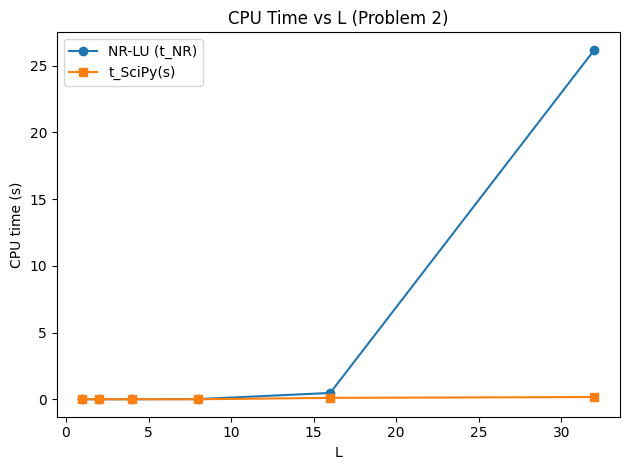

In [44]:
L_list = [1, 2, 4, 8, 16, 32]
rows = solve_problem2_for_L_list(L_list, r=1.0, A_pos=(0,0), B_pos=None, VA=0.0, VB=1.0)

# Make a DataFrame for clean presentation
df_p2 = pd.DataFrame(rows).sort_values("L").reset_index(drop=True)
display(df_p2)

# Plot CPU timing vs L (NR vs reference) – 1 chart per figure, no explicit colors
timing_cols = [c for c in df_p2.columns if c.startswith("t_") and c.endswith("(s)")]
ref_cols = [c for c in timing_cols if c != "t_NR(s)"]  # ensure we don't pick t_NR twice
ref_col = ref_cols[0] if ref_cols else None

plt.figure()
plt.plot(df_p2["L"], df_p2["t_NR(s)"], marker="o", label="NR-LU (t_NR)")
if ref_col is not None:
    plt.plot(df_p2["L"], df_p2[ref_col], marker="s", label=ref_col)
plt.xlabel("L")
plt.ylabel("CPU time (s)")
plt.title("CPU Time vs L (Problem 2)")
plt.legend()
plt.tight_layout()
plt.show()

### Analysis (Problem 2)

- **Monotonic trend**: As $L$ grows, total current out of $B$ decreases (the network gets “larger” and overall conductance reduces).
- **Validation**: For $L=2$, the grid voltages show both neighbours of $B$ at $2/3\,\mathrm{V}$ ⇒ $I_B = 2 \times (1 - 2/3) = 2/3\,\mathrm{A}$, matching theory.
- **Agreement**: NR-LU and SciPy/NumPy currents agree up to machine precision ($\mathrm{abs\_diff} \sim 10^{-15}$).
- **Timing**: SciPy/NumPy is much faster than the pure-Python NR-LU; the gap widens as the number of unknowns grows (roughly $O(n^3)$ scaling for dense LU).